## AR Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

In this case an AR(1) model is used.

The approximation is:
$$ \Lambda(\theta_0, \theta_1) = \prod_{t=1}^N \frac{p(\theta_0 | x_t, x_{t-1})}{p(\theta_1 | x_t, x_{t-1})}\left(\prod_{t=0}^{N-1}\frac{p(\theta_0 | x_t)}{p(\theta_1 | x_t)}\right)^{-1}$$



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
import pdb

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/../systematics/carl')

import carl

matplotlib.style.use('ggplot')

np.random.seed(1234)

In [20]:
n_samples = 250000
alpha_value = 0.5
sigma_2_value = 1.**2

shared_alpha = theano.shared(alpha_value, name="alpha")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")

bounds = [(0.3, 0.7)]
n_points = 15

As = np.linspace(bounds[0][0],bounds[0][1], n_points)


class AR:
    def __init__(self, c, alpha, sigma_2):
        self.c = c
        self.alpha = alpha
        self.sigma_2 = sigma_2
    
    def sample(self, alpha=0.2, sigma_2=1., n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        for i in range(1,n_timesteps):
            time_serie[i] = self.c + alpha*time_serie[i-1] + noise[i]

        return time_serie.reshape(time_serie.shape[0],1), time_serie.reshape(time_serie.shape[0],1)
    
    def nll(self, X):
        T = X.shape[0]
        ll = -0.5*np.log(2.*np.pi) -0.5*np.log(self.sigma_2/(1.-self.alpha**2))
        ll += -((X[0] - (self.c/(1.-self.alpha)))**2)/((2.*self.sigma_2)/(1.-self.alpha**2))
        ll += -((T - 1)/2.)*np.log(2.*np.pi) - ((T - 1)/2.)*np.log(self.sigma_2)
        ll += -(((X[1:] - self.c - self.alpha*X[:-1])**2)/(2.*self.sigma_2)).sum()
        return -ll.eval()
    
    def rvs(self, n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(alpha=self.alpha.eval(),sigma_2=self.sigma_2.eval(),
                     n_timesteps=n_samples,rng=rng)[0]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [3]:
p0 = AR(c = 0., alpha=shared_alpha, sigma_2=shared_sigma_2)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = AR(c = 0., alpha = theano.shared(0.3, name="alpha_1"),
        sigma_2 = theano.shared(sigma_2_value,name="sigma_2_1"))
rng = np.random.RandomState(1234)

X_true = p0.rvs(15000,random_state=rng)

In [4]:
exact_contours = np.zeros(len(As))
zeroes = np.zeros(len(As))
for i,a in enumerate(As):
    shared_alpha.set_value(a)

    exact_contours[i] = p0.nll(X_true)
    #print('Iteration {0}: {1}'.format(i,a))


exact_contours = 2. * (exact_contours - exact_contours.min()) * len(X_true)


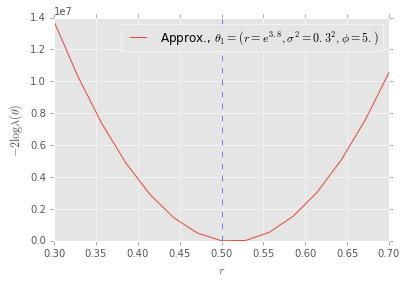

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(As, exact_contours, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=5.)$")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")

ax.legend()
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=alpha_value,linestyle='dashed',alpha=0.5)
#plt.savefig('likelihood_comp.pdf')
plt.show()

-5.90341100659 5.94524457084
-4.42689369505 4.77152910099


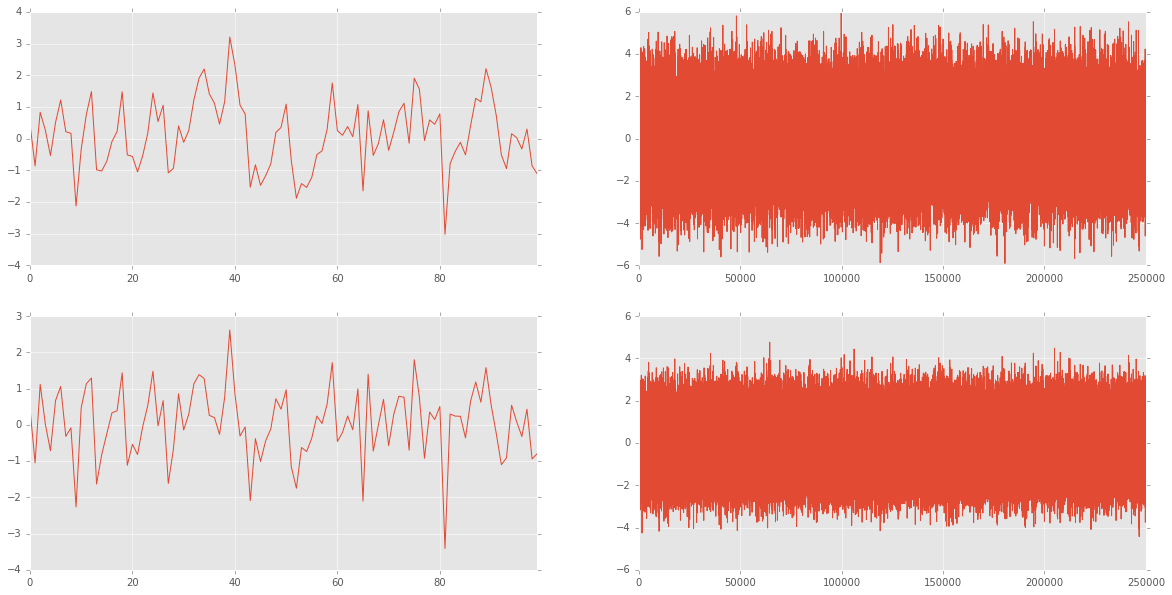

In [6]:
serie1 = p0.rvs(n_samples).ravel()
serie2 = p1.rvs(n_samples).ravel()
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [7]:
from carl.learning import make_parameterized_classification

X, y = make_parameterized_classification(
    p0, p1,
    500000, 
    [(shared_alpha, np.linspace(bounds[0][0],bounds[0][1], num=8))],
    random_state=1234)

In [8]:
print X
print y

[[ 0.47143516  0.3       ]
 [-1.04954515  0.3       ]
 [ 1.11784342  0.3       ]
 ..., 
 [ 0.82150054  0.7       ]
 [ 1.06134052  0.7       ]
 [ 0.715305    0.7       ]]
[ 0.  0.  0. ...,  1.  1.  1.]


In [9]:
max_len = 2
X0_serie = []
y0_serie = []
X1_serie = []
y1_serie = []

X0 = X[y == 0]
X1 = X[y == 1]
for i in xrange(X0.shape[0]-max_len+1):
    # ensure that is from same time serie
    if X0[i][-1] == X0[i+max_len-1][-1]:
        X0_serie.append(X0[i:i+max_len])
    if X1[i][-1] == X1[i+max_len-1][-1]:
        X1_serie.append(X1[i:i+max_len])
X0_serie = np.array(X0_serie)
X1_serie = np.array(X1_serie)

X_serie = np.vstack((
     X0_serie,
     X1_serie))
y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
y_serie[X0_serie.shape[0]:] = 1

X_cond = np.vstack((
     X0,
     X1))
y_cond = np.zeros(X0.shape[0]*2,dtype=np.int)
y_cond[X0.shape[0]:] = 1


In [10]:
print(X_serie.shape)

(499984, 2, 2)


In [11]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def make_model_join():
    model = Sequential()
    model.add(SimpleRNN(5, input_shape=(max_len, 2)))
    model.add(Dense(5, activation='tanh'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    sgd = Adam(clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model

def make_model_single():
    model = Sequential()
    model.add(Dense(5, activation='tanh', input_shape=(2,)))
    model.add(Dense(5, activation='tanh'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    sgd = Adam(clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model

clf_join = KerasClassifier(make_model_join, nb_epoch=10, verbose=2)
clf_single = KerasClassifier(make_model_single, nb_epoch=10, verbose=2)

clf_single.fit(X=X_cond, y=y_cond)
clf_join.fit(X=X_serie, y=y_serie)

#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/10
6s - loss: 0.6904
Epoch 2/10
7s - loss: 0.6896
Epoch 3/10
6s - loss: 0.6894
Epoch 4/10
7s - loss: 0.6893
Epoch 5/10
6s - loss: 0.6890
Epoch 6/10
6s - loss: 0.6889
Epoch 7/10
6s - loss: 0.6889
Epoch 8/10
6s - loss: 0.6887
Epoch 9/10
7s - loss: 0.6886
Epoch 10/10
7s - loss: 0.6886
Epoch 1/10
12s - loss: 0.6856
Epoch 2/10
12s - loss: 0.6833
Epoch 3/10
11s - loss: 0.6820
Epoch 4/10
11s - loss: 0.6814
Epoch 5/10
13s - loss: 0.6813
Epoch 6/10
12s - loss: 0.6811
Epoch 7/10
13s - loss: 0.6810
Epoch 8/10
12s - loss: 0.6810
Epoch 9/10
12s - loss: 0.6809
Epoch 10/10
14s - loss: 0.6808


Using Theano backend.


In [12]:
print clf_join.predict_proba(X_serie)

[[ 0.48478973  0.51521027]
 [ 0.49269313  0.50730687]
 [ 0.47251076  0.52748924]
 ..., 
 [ 0.40503776  0.59496224]
 [ 0.50749969  0.49250033]
 [ 0.50096565  0.49903435]]


In [13]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf_single, bins=30, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_cond,y=y_cond)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x90d2190>,
            bins=30, cv='prefit', method='histogram'),
        random_state=0)

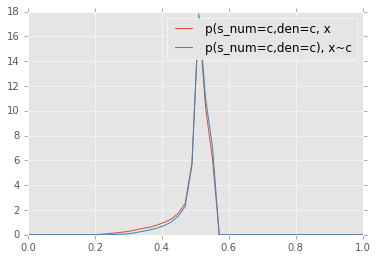

In [14]:
reals2 = np.linspace(0, 1)
cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [15]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 50000
def objective(theta, X_true = X_true, random_state=0):    
    print(theta)
    shared_alpha.set_value(theta[0])
    serie1 = p0.rvs(n_samples)
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+1))
    X0[:,:-1] = serie1
    X0[:,-1] = theta
    
    # Fit ratio
    ratio_join = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_join, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=30))

    #serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
    serie2 = p1.rvs(n_samples,random_state=random_state)
    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+1))
    X1[:,:-1] = serie2
    X1[:,-1] = theta

    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    ratio_join.fit(X_serie, y_serie)
    
    # Fit ratio
    ratio_single = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_single, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=30))
    
    X_single = X_serie[:,0,:]
    y_single = y_serie[:]
    
    ratio_single.fit(X_single, y_single)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+1))
    X_true_[:,:-1] = X_true
    X_true_[:,-1] = theta
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    
    r_join = ratio_join.predict(X_true_serie, log=True)
    r_single = -ratio_single.predict(X_true_serie[:,0,:], log=True)
    
    r_full = r_join[1:] + r_single[:-1]
    #r_full = r_single
    
    print r_full[np.isinf(r_full)].shape
    value = -np.mean(r_full[np.isfinite(r_full)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
    print(value)
    return value

In [16]:
# Evaluate log-likelihood ratio
n_points = 15
shared_alpha.set_value(alpha_value)
#X_true = p0.rvs(15000, random_state=rng)

approx_contours = np.zeros(len(As))
zeroes = np.zeros(len(As))
for i,a in enumerate(As):
    approx_contours[i] = objective([a],X_true=X_true)
    print('Iteration {0}: {1}'.format(i,a))


approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)


[0.29999999999999999]
(4,)
-0.00126721299991
Iteration 0: 0.3
[0.32857142857142857]
(2,)
-0.00158572929837
Iteration 1: 0.328571428571
[0.35714285714285715]
(3,)
-0.00980587552597
Iteration 2: 0.357142857143
[0.38571428571428568]
(1,)
-0.0159869304921
Iteration 3: 0.385714285714
[0.41428571428571426]
(2,)
-0.0212391710564
Iteration 4: 0.414285714286
[0.44285714285714284]
(1,)
-0.0247134619546
Iteration 5: 0.442857142857
[0.47142857142857142]
(1,)
-0.0275141441568
Iteration 6: 0.471428571429
[0.5]
(2,)
-0.0293850849566
Iteration 7: 0.5
[0.52857142857142858]
(1,)
-0.0283306726122
Iteration 8: 0.528571428571
[0.55714285714285716]
(1,)
-0.0273620337521
Iteration 9: 0.557142857143
[0.58571428571428563]
(0,)
-0.0246460288232
Iteration 10: 0.585714285714
[0.61428571428571432]
(0,)
-0.0212035949113
Iteration 11: 0.614285714286
[0.64285714285714279]
(0,)
-0.0177879996545
Iteration 12: 0.642857142857
[0.67142857142857149]
(1,)
-0.0128618281702
Iteration 13: 0.671428571429
[0.69999999999999996]
(

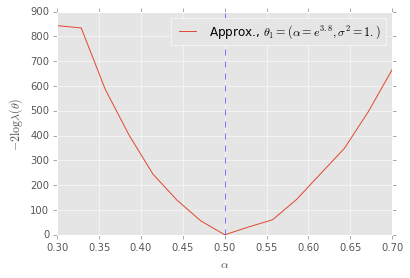

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(As, approx_contours, label=r"Approx., $\theta_1=(\alpha=0.5,\sigma^2=1.)$")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")

ax.legend()
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=alpha_value,linestyle='dashed',alpha=0.5)
#plt.savefig('likelihood_comp.pdf')
plt.show()

In [18]:
from GPyOpt.methods import BayesianOptimization
bounds = [(0.1,0.5)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 0.22384972]
(2,)
0.0184754769886
[ 0.23066371]
(3,)
0.0150133024872
[ 0.10198037]
(0,)
0.0722224915823
[ 0.42627496]
(3,)
-0.0235287894299
[ 0.5]
(2,)
-0.0293850849566
[ 0.5]
(2,)
-0.0293850849566
*Optimization completed:
   -Method converged.


0

In [ ]:
approx_MLE = solver.x_opt
print solver.x_opt
print("Approx. MLE =", approx_MLE)

In [ ]:
solver.plot_acquisition()

In [ ]:
solver.plot_convergence()

In [ ]:
from scipy.optimize import minimize
shared_alpha.set_value(alpha_value)
# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[0.4])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

In [ ]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]
#bounds = [(38., 58.0)]
As = np.linspace(bounds[0][0],bounds[0][1], 50)

n_points = 30

clf = clf
n_samples = n_samples
#As = np.linspace(*bounds[0], 100)
nll_gp, var_gp = solver.model.predict(As.reshape(-1, 1))
nll_gp = 2. * (nll_gp - nll_gp.min()) * len(X_true)
gp_ratios = nll_gp
# STD
std_gp = np.sqrt(4*var_gp*len(X_true)*len(X_true))
std_gp[np.isnan(std_gp)] = 0.
gp_std = std_gp
# 95% CI
q1_gp, q2_gp = solver.model.predict_quantiles(As.reshape(-1, 1))
q1_gp = 2. * (q1_gp - r.fun) * len(X_true)
q2_gp = 2. * (q2_gp - r.fun) * len(X_true)
gp_q1 = q1_gp
gp_q2 = q2_gp

In [ ]:
#bounds = [(42.,46.)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
print gp_ratios

ax.plot(As, gp_ratios, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
#ax.fill_between(As,(gp_ratios - gp_std).ravel(),(gp_ratios + gp_std).ravel(),
#                     color='g',alpha=0.2)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")
#plt.legend()


ax.legend()
ax.set_ylim(0, 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=0.3**2,ymin=0.,ymax=4.,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model